In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import align

import cryo_tools

/Data/Packages/Research/miniconda3/envs/cryo_tools/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/david/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [26]:
config = {}

config["IMAGES"] = {"N_PIXELS": 128, "PIXEL_SIZE": 0.3, "SIGMA": 0.5}

config["PROCESSING"] = {"SNR": 0.1, "DEFOCUS": 0.5, "AMP": 0.1, "B_FACTOR": 1.0}

# Check that everything works

cryo_tools.utils.check_params(config)

In [4]:
ref_model = mda.Universe("../Tutorials/total_traj_frames/traj_1.pdb")
ref_model.atoms.translate(-ref_model.atoms.center_of_mass())

<AtomGroup with 73 atoms>

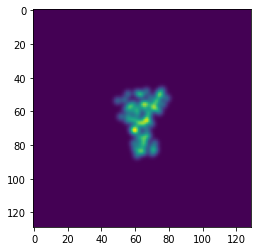

In [27]:
image = cryo_tools.simulating.gen_img(
    ref_model.select_atoms("all").positions.T, config["IMAGES"]
)

plt.imshow(image)

In [12]:
def apply_ctf(image, image_params, proc_params):
    def calc_ctf(n_pixels, pixel_size, amp, phase, b_factor):
        ctf = np.zeros((n_pixels, n_pixels), dtype=np.complex128)

        freq_pix_1d = np.fft.fftfreq(n_pixels, d=pixel_size)

        x, y = np.meshgrid(freq_pix_1d, freq_pix_1d)

        freq2_2d = x**2 + y**2
        imag = np.zeros_like(freq2_2d) * 1j

        env = np.exp(-b_factor * freq2_2d * 0.5)
        ctf = (
            amp * np.cos(phase * freq2_2d * 0.5)
            - np.sqrt(1 - amp**2) * np.sin(phase * freq2_2d * 0.5)
            + imag
        )

        return ctf * env / amp

    elecwavel = 0.019866
    phase = proc_params["DEFOCUS"] * np.pi * 2.0 * 10000 * elecwavel

    ctf = calc_ctf(
        image.shape[0],
        image_params["PIXEL_SIZE"],
        proc_params["AMP"],
        phase,
        proc_params["B_FACTOR"],
    )

    conv_image_ctf = np.fft.fft2(image) * ctf

    image_ctf = np.fft.ifft2(conv_image_ctf).real

    return ctf, image_ctf

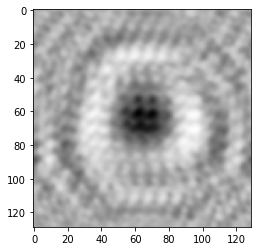

In [28]:
ctf, image_ctf = apply_ctf(image, config["IMAGES"], config["PROCESSING"])

plt.imshow(image_ctf, cmap="Greys_r")

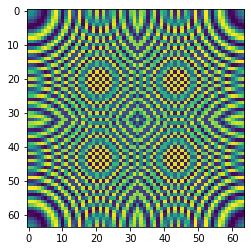

In [18]:
plt.imshow(ctf.real)